# ForceSMIP Example: LIM

The goal of this notebook is to demonstrate the use of a linear inverse model (LIM) optimal perturbation filter (LIMopt) to estimate the forced and unforced components of climate change for a single variable, with surface air temperature used as an example, as in Frankignoul et al. (2017, https://doi.org/10.1175/JCLI-D-17-0009.1). LIMs ordinarily describe the evolution of a system from one time to the next, using a lagged covariance to evolve the system from one timestep to the next, basically reducing the evolution of the system (represented by a truncated set of EOFs/principal components) by a simple multi-dimensional ODE. The basic idea of LIMopt is to solve for the "optimal initial perturbation" that grows into the largest perturbation on a specified timescale. In the settings below, the lag time considered for the LIM is 3 months (as is traditional) and we consider perturbations that grow into the maximum perturbation after a time of 5 years (60 months); this should be an integer multiple of the LIM lag time, and it should be longer than the ENSO timescale, but otherwise it is a free parameter that you should play around with (in fact, this notebook departs from the original recommendation of 30 months based on the observation that some models have a longer than normal ENSO timescale). 

Some other references to consider are Solomon and Newman (2012, https://doi.org/10.1038/nclimate1591), who used this method as an ENSO filter, using a shorter optimal perturbation timescale, and Wills et al. (2020, https://doi.org/10.1175/JCLI-D-19-0855.1), who compare LIMopt with LFCA (in the supplemental material). 

#### Outline:

* LIMopt background
* Notes on setup with conda
* Import of key packages
* User-specified options
* Loading in the ForceSMIP data
    * Defining a function to read in data
    * Loading monthly anomaly maps for the evaluation data
    * Loading monthly anomaly maps for the training data
    * Calculating the ensemble-mean monthly anomaly maps for the training data
* Apply LIMoppt to the training models for various values of the hyperparameters (EOF truncation and number of low-frequency components included in the forced response)
* Evaluate the skill of LIMopt for the training data
* Apply LIMopt to the evaluation data for specified hyperparameters

### Data structure, training and evaluation data

LIMs analyze a data matrix with a size of the number of timesteps (n<sub>t</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>). The notebook is set up to use monthly surface air temperature values, though you can change the variable used or try modifying it to use annual means. 

<p align="center">
  <img width=800 src="figs/anomaly_maps.png" />
</p>

This data matrix will be created for the **training data** and the **evaluation data**. For the training data, we have many ensemble members, and we can compute the forced response as the ensemble average. For the evaluation data, we only have one realization from each model, just as we only have one realization of the real world. The challenge of ForceSMIP is to come up with methods that can approximate the forced response from these single realizations, removing internal variability as we would if we were able to take an ensemble mean.

### LIMopt

The basis to set up the LIM is principal component analysis (aka EOF analysis). From this we find a set of basis functions (EOFs) that efficiently describe the variability in the data matrix. A key parameter in the LIM is the number of EOFs to include, which is labelled `trucation` in the code. LIMopt then looks for the linear combination of the included EOFs that grows into the maximum perturbation after `optlag` months. This notebook won't get into the details of the linear algebra, which can be found in the above references papers, but the LIMopt ends up being a singular vectory of the lagged covariance matrix (with `lag` month lag time) raised to an integer power determined by `optlag` divided by `lag`. Basically, this looks at the evolution of the system over a number of lags that is equivalent to optlag, by multiplying the state vector by the evolution matrix (determined by the lagged covariance matrix) multple times until optlag has been reached. For more details on LIM, see Matt Newman's lecture. For more on LIMopt, see the reference literature. 

### Forced response estimate

To reconstruct an estimate of the forced response, we multiply the LIMopt pattern by its timeseries to once again make a matrix with dimensions of the number of timesteps (n<sub>t</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>). Note that this does not use the iterative filter described in Frankignoul et al. (2017) and is equivalent to setting $\tau_1 = 0$ in there equations. Wills et al. (2020) compares $\tau_1 = 0$ with $\tau_1 = 20$ years used in Frankignoul et al. (2017) and finds only small differences (though it is worth exploring whether that is true for ForceSMIP as well). 

### Utilizing the training data

The training data is used for choosing the hyperparamter `trucation`. Here, the notebook simply tries a few different values of truncation, then compares the LIMopt forced reponse estimate to the "right answer", which for the case of the training data is the ensemble mean. This notebook shows a few different possible skill estimates, and the user is free to choose which values work best for their needs depending on what they want to optimize, i.e., anomaly correlation coefficient (ACC) vs. root-mean square error (RMSE), spatial pattern of trends vs. spatiotemporal variance at monthly timescales. It might also make sense to use the training data to optimize `lag` and `optlag`. 

## Some setup notes

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)).

To create this environment we ran `conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn  matplotlib cartopy nc-time-axis ipython ipykernel eofs scipy`

> Note: You may need to check your shell to activate conda. To determine your shell, you can run `echo $SHELL`. You can then activate conda (based on your shell type, e.g., `conda init bash`). You may subsequently need to re-source your shell (e.g., `source ~/.bashrc` for bash).

Activate your environment with: `conda activate forcesmip`

> Note: Alternatively, you can try `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages (code starts here)

In [1]:
# I/O / data wrangling
import glob
import re
import numpy as np
import xarray as xr
import xcdat as xc

# data analysis
from eofs.standard import Eof

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define LIM Function and SVD

In [2]:
"""
Linear Inverse Model (Optimal Perturbation Filtering)

This function computes the LIMopt patterns directly, without computing the associated LIM.
Other codes will be provided within the hackathon that use LIM.

Author: Robb Jnglin Wills (ETH Zurich)

Reference:  Frankignoul, C., G. Gastineau, and Y. Kwon, 2017: Estimation of the 
            SST Response to Anthropogenic and External Forcing and Its Impact on 
            the Atlantic Multidecadal Oscillation and the Pacific Decadal 
            Oscillation. J. Climate, 30, 9871–9895, https://doi.org/10.1175/JCLI-D-17-0009.1.
            
            See also: Supplemental Information of Wills et al. 2020: Pattern recognition 
            methods to separate forced responses from internal variability in climate model 
            ensembles and observations. Journal of Climate, 33, 8693–8719.
"""
import numpy as np
import xarray as xr
from eofs.standard import Eof

### Main LIM function ###
def limopt(x, lag, optlag, cutoff, weights, **kwargs):
    if x.ndim!=2:
        raise ValueError('x must have dimension 2 for LIM')
    
    # Scale vector from weights
    scale = np.sqrt(np.transpose(weights)/np.sum(weights))
    
    # center data
    x = x - np.mean(x,axis=0)
    xs = x * scale.T
    
    # Compute EOFs using eofs package
    # xarray version: eofs_xr=Eof(xs, center=False, ddof=1)
    eofs_xr=Eof(xs.values, center=False, ddof=1)
    # Principal component time series (PC_k)
    pcs=eofs_xr.pcs(npcs=truncation, pcscaling=1)
    
    # Compute lag-1 covariance of PCs (lag-0 covariance is identity matrix)
    C1 = np.dot(np.transpose(pcs[:-lag,:]),pcs[lag:,:])
    
    # Raise the lag-1 covariance matrix to the power of the optimal perturbation time divided by the lag time
    G = np.linalg.matrix_power(C1, int(optlag/lag))
    
    # svd of G
    Psi, r, Phi = csvd(G)
    
    # compute LIMopt pattern and its timeseries alpha
    uvec=eofs_xr.eofs(neofs=truncation, eofscaling=1).T@Psi # u_k
    # xarray version: lfcs=xs@uvec # timeseries of LIMopts
    alphas = np.dot(xs, uvec)
    
    limopts=eofs_xr.eofs(neofs=truncation, eofscaling=2).T@Phi # LIMopt patterns
    
    # Choose positive sign of LIMopts/alphas
    for j in range(limopts.shape[1]):
        if np.dot(limopts[:,j], scale.flatten())<0:
            limopts[:,j] = -limopts[:,j]
            alphas[:,j] = -alphas[:,j]
    limopts=limopts/scale # Re-scale LIMopts (non-weighted)
    limopts=np.transpose(limopts)
    
    return limopts, alphas

def csvd(a):
    
    (m,n) = a.shape
    if m>=n:
        (u,s,v) = np.linalg.svd(a,0)
        v = np.transpose(v)
    else:
        (v,s,u) = np.linalg.svd(a.transpose(),0)
        u = np.transpose(u)
        
    return u, s, v

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [3]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [14]:
root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # where is the data on the machine you're using

ncvar = "tos"  # CMIP variable name to be used

lag = 3 # - you can also try varying this parameter
optlag = 60 # - you can also try varying this parameter (must be integer multiple of lag)
truncations = (20, 60, 200) # different values of the EOF truncation to try

# choose models for training
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2","CanESM5","MIROC-ES2L","MIROC6","MPI-ESM1-2-LR"]
n_members = 10  # number of members for training

# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3

# no need to modify the training or reference period for LIMopt
tv_time_period = evalPeriods[eval_tier] # ("1950-01-01","2022-12-30")  # period of time to consider data for training
reference_period = tv_time_period # anomalies will be with respect to mean over entire period (convectional for LIMopt)

### Define a function to read in data

We're going to loop over many models and realizations for training and evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [15]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the annual anomalies
    relative to a user-defined reference_period. The function returns arrays
    of the dimensions (time, lat, lon), the 3D anomaly map, and the global
    mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : annual average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : annual average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # take annual average (commented out because we want monthly data)
    # Note: xcdat takes the annual average ignoring NaN values
    # ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/evaluation data as well. That way the training and evaluation data will be consistent.

In [16]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_anomaly_maps = {}
missing_data_mask = {}
vid = cmipVar[ncvar]

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_anomaly_maps[model] = ts_3d
    
    # create mask for missing data
    tmp = np.mean(ts_3d, axis=0)
    missing_data_mask[model] = np.where(np.isnan(tmp), np.nan, 1)

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J


### Loop over training models and retrieve monthly anomaly maps

In [17]:
# initialize dictionary to store data
global_mean_timeseries = {}
anomaly_maps = {}
anomaly_map_emean = {}
missing_data_mask_training = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models
for im, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    anomaly_maps[model] = {}
    anomaly_map_emean[model] = 0
    missing_data_mask_training[model] = {}
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    # loop over model members
    for imm, member in enumerate(members):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
        # store first N anomaly maps from training models
        # also store all data for the validation models
        if ((imm < n_members) & (model in training_models)):# | (model in validation_models):
            # store masked data in array
            anomaly_maps[model][member] = ts_3d
        # ensemble mean anomaly map
        anomaly_map_emean[model] = anomaly_map_emean[model] + ts_3d/len(members)
        # save global mean time series for all model members
        global_mean_timeseries[model][member] = ts_gm
        # create mask for missing data
        tmp = np.mean(ts_3d, axis=0)
        missing_data_mask_training[model] = np.where(np.isnan(tmp), np.nan, 1)
        # update progress
        print(".", end="")
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: CESM2 (50 members)
..................................................
Time elapsed: 34.81560945510864 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 18.256431579589844 seconds

3 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 22.129621744155884 seconds

4 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 36.06755018234253 seconds

5 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 21.611554384231567 seconds



## LIMopt of training members

Now we apply LIMopt to the specified number of members for each of the specified training models. We use the different values of `truncation` that were specified. Depending how much training data you use and how many values of `truncation` you try, this could take a while.  

In [18]:
n_models = len(training_models)

# initialize dictionaries for LIMopt output
alphas_all = {}
limopts_all = {}
icol_ret_all = {}

for ig, model in enumerate(training_models):
    
    # initialize nested dictionary for member data
    alphas_all[model] = {}
    limopts_all[model] = {}
    icol_ret_all[model] = {}
    
    members  = global_mean_timeseries[model].keys()
    training_members = anomaly_maps[model].keys()
    print(model)
    # start timer
    stime = clocktime.time()
    for im, member in enumerate(training_members):
    
        print("Member " + str(im + 1) + " / " + str(len(training_members)))

        # initialize nested dictionary for member data
        alphas_all[model][member] = {}
        limopts_all[model][member] = {}
        
        # convert missing data mask from nans to zeros
        mask = np.nan_to_num(missing_data_mask_training[model], nan=0)

        # this is the data from each training model/member
        sst_anomalies = anomaly_maps[model][member]

        # dimensions of the data matrix
        n_timesteps = len(global_mean_timeseries[model][member])
        nfeatures = nlat * nlon

        # extract coordinate vectors (same for all models, so could be moved out of the loop)
        k = list(anomaly_maps[model].keys())
        lon_axis = anomaly_maps[model][k[0]].lon
        lat_axis = anomaly_maps[model][k[0]].lat
        time = anomaly_maps[model][k[0]].time

        # create cos(lat) weighting, with mask for missing data 
        y, x = np.meshgrid(lat_axis,lon_axis)
        area = np.cos(y*np.pi/180.) * np.transpose(mask)
        area_weights = np.reshape(area,(nfeatures,1),order='F')

        # combine lat & lon into a single spatial dimension
        x_all = sst_anomalies.stack(shape=['lat','lon'])

        # these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
        icol_ret = np.where(area_weights!=0)
        icol_disc = np.where(area_weights==0)
        # remove missing spatial points from x and area_weights
        x = x_all[:,icol_ret[0]]
        area_weights = np.transpose(area_weights[icol_ret[0],:])

        icol_ret_all[model] = icol_ret
        # loop over the chosen EOF truncations and perform LIMopt using the function defined above
        for truncation in truncations:
            limopts_all[model][member][str(truncation)], alphas_all[model][member][str(truncation)] =  limopt(x, lag, optlag, truncation, area_weights)

    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

CESM2
Member 1 / 10
Member 2 / 10
Member 3 / 10
Member 4 / 10
Member 5 / 10
Member 6 / 10
Member 7 / 10
Member 8 / 10
Member 9 / 10
Member 10 / 10

Time elapsed: 111.4069139957428 seconds

CanESM5
Member 1 / 10
Member 2 / 10
Member 3 / 10
Member 4 / 10
Member 5 / 10
Member 6 / 10
Member 7 / 10
Member 8 / 10
Member 9 / 10
Member 10 / 10

Time elapsed: 109.31387233734131 seconds

MIROC-ES2L
Member 1 / 10
Member 2 / 10
Member 3 / 10
Member 4 / 10
Member 5 / 10
Member 6 / 10
Member 7 / 10
Member 8 / 10
Member 9 / 10
Member 10 / 10

Time elapsed: 108.36759948730469 seconds

MIROC6
Member 1 / 10
Member 2 / 10
Member 3 / 10
Member 4 / 10
Member 5 / 10
Member 6 / 10
Member 7 / 10
Member 8 / 10
Member 9 / 10
Member 10 / 10

Time elapsed: 102.24586033821106 seconds

MPI-ESM1-2-LR
Member 1 / 10
Member 2 / 10
Member 3 / 10
Member 4 / 10
Member 5 / 10
Member 6 / 10
Member 7 / 10
Member 8 / 10
Member 9 / 10
Member 10 / 10

Time elapsed: 107.14151215553284 seconds



## Evaluate LIMopt of training members

Now, we loop through all of the LIMopt output we created, generating a forced response estimate (by generating a data matrix from alpha*LIMopt) and outputting error metrics, which are then plotted in the cells below. Each error metric has dimensions of `[len(training_models), n_members, len(truncations)]`.

In [19]:
# time axis
time_plot = [t.year + t.month/12 for t in time.values]

# intialize skill metrics
mse = np.zeros((n_models,n_members,len(truncations)))
corr = np.zeros((n_models,n_members,len(truncations)))
mse_trend = np.zeros((n_models,n_members,len(truncations)))
corr_trend = np.zeros((n_models,n_members,len(truncations)))
mse_raw = np.zeros((n_models,n_members))
corr_raw = np.zeros((n_models,n_members))
mse_trend_raw = np.zeros((n_models,n_members))
corr_trend_raw = np.zeros((n_models,n_members))

cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
cosw = cosw/np.mean(cosw)

# loop over training models/members, and truncation to evaluate the LIMopt estimate of the forced response against the ensemble mean
for ig, model in enumerate(training_models):
    print(model)
    # start timer
    stime = clocktime.time()
    # ensemble mean for each model
    X_emean = anomaly_map_emean[model].values
    X_emean = xr.DataArray(X_emean, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
    # names for training ensemble members
    training_members = anomaly_maps[model].keys()
    for im, member in enumerate(training_members):
        X_total = anomaly_maps[model][member].values
        X_total = xr.DataArray(X_total, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
        # Statistics for spatiotemporal variance
        sigma_total = np.sqrt((X_total*X_total*cosw).mean('lon').mean('lat').mean('time').values)
        sigma_emean = np.sqrt((X_emean*X_emean*cosw).mean('lon').mean('lat').mean('time').values)
        corr_raw[ig,im] = (X_total*X_emean*cosw).mean('lon').mean('lat').mean('time').values/(sigma_total*sigma_emean)
        diff = X_total-X_emean
        mse_raw[ig,im] = (diff*diff*cosw).mean('lon').mean('lat').mean('time').values
        # Compute linear trend
        X_total_trend = X_total.polyfit('time',1).isel(degree=0).polyfit_coefficients
        X_emean_trend = X_emean.polyfit('time',1).isel(degree=0).polyfit_coefficients
        # Pattern MSE (including global mean difference)
        diff = X_total_trend-X_emean_trend
        mse_trend_raw[ig,im] = (diff*diff*cosw).mean('lon').mean('lat').values
        # Zero mean
        X_total_trend = X_total_trend - (X_total_trend*cosw).mean('lon').mean('lat')
        X_emean_trend = X_emean_trend - (X_emean_trend*cosw).mean('lon').mean('lat')
        # Statistics for trend
        sigma_total_trend = np.sqrt((X_total_trend*X_total_trend*cosw).mean('lon').mean('lat').values)
        sigma_emean_trend = np.sqrt((X_emean_trend*X_emean_trend*cosw).mean('lon').mean('lat').values)
        corr_trend_raw[ig,im] = (X_total_trend*X_emean_trend*cosw).mean('lon').mean('lat').values/(sigma_total_trend*sigma_emean_trend)
        for it, truncation in enumerate(truncations):
            # extract relevant LIMopts and their timeseries from dictionary
            alphas = alphas_all[model][member][str(truncation)]
            limopts = limopts_all[model][member][str(truncation)]
            # put back in missing data 
            icol_ret = icol_ret_all[model]
            nins = nfeatures - len(icol_ret[0]) #np.size(icol_disc[0])
            nrows = limopts.shape[0]
            limopts_aug = np.zeros((nrows,limopts.shape[1]+nins))
            limopts_aug[:] = np.nan
            limopts_aug[:,icol_ret[0]] = limopts
            # forced response estimate from LIMopt
            X_forced = np.matmul(alphas[:,0:1],limopts_aug[0:1,:])
            X_forced = X_forced.reshape(n_timesteps,nlat,nlon)
            X_forced = xr.DataArray(X_forced, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
            # Statistics for spatiotemporal variance
            sigma_forced = np.sqrt((X_forced*X_forced*cosw).mean('lon').mean('lat').mean('time').values)
            sigma_emean = np.sqrt((X_emean*X_emean*cosw).mean('lon').mean('lat').mean('time').values)
            corr[ig,im,it] = (X_forced*X_emean*cosw).mean('lon').mean('lat').mean('time').values/(sigma_forced*sigma_emean)
            diff = X_forced-X_emean
            mse[ig,im,it] = (diff*diff*cosw).mean('lon').mean('lat').mean('time').values
            # Compute linear trend
            X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients
            X_emean_trend = X_emean.polyfit('time',1).isel(degree=0).polyfit_coefficients
            # Pattern MSE (including global mean difference)
            diff = X_forced_trend-X_emean_trend
            mse_trend[ig,im,it] = (diff*diff*cosw).mean('lon').mean('lat').values
            # Zero mean
            X_forced_trend = X_forced_trend - (X_forced_trend*cosw).mean('lon').mean('lat')
            X_emean_trend = X_emean_trend - (X_emean_trend*cosw).mean('lon').mean('lat')
            # Statistics for trend
            sigma_forced_trend = np.sqrt((X_forced_trend*X_forced_trend*cosw).mean('lon').mean('lat').values)
            sigma_emean_trend = np.sqrt((X_emean_trend*X_emean_trend*cosw).mean('lon').mean('lat').values)
            corr_trend[ig,im,it] = (X_forced_trend*X_emean_trend*cosw).mean('lon').mean('lat').values/(sigma_forced_trend*sigma_emean_trend)
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

CESM2

Time elapsed: 26.883152961730957 seconds

CanESM5

Time elapsed: 27.438424348831177 seconds

MIROC-ES2L

Time elapsed: 27.567790985107422 seconds

MIROC6

Time elapsed: 27.92644214630127 seconds

MPI-ESM1-2-LR

Time elapsed: 27.273006200790405 seconds



### Pattern Correlation and RMSE of Trend

**(left; up = skillful)** Here we have computed the pattern correlation with the ensemble mean for trends over the full period (corresponding to the chosen Tier). The pattern correlation is averaged over all training models and training members, then plotted against `truncations`. 

**(right; down = skillful)** Here we have computed the spatial RMSE in the trend, with respect to the ensemble mean trend, over the full period (corresponding to the chosen Tier). The MSE is averaged over all training models and training members, then square rooted, then plotted against `truncations`. 

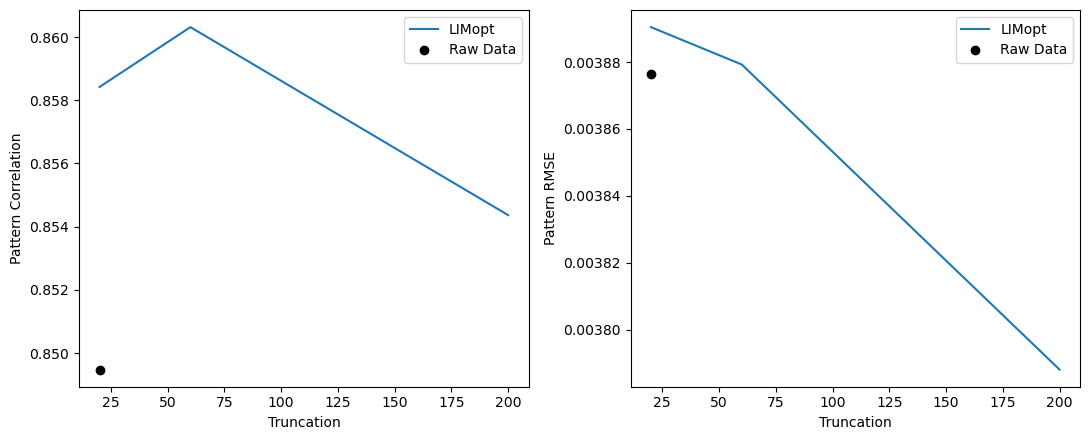

In [20]:
f=plt.figure(figsize=(11, 4.5))
plt.subplot(1, 2, 1)
plt.plot(truncations, np.mean(np.mean(corr_trend,axis=1),axis=0))
plt.plot(np.min(truncations),np.mean(np.mean(corr_trend_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['LIMopt','Raw Data'])
plt.xlabel("Truncation")
plt.ylabel("Pattern Correlation")
plt.subplot(1, 2, 2)
plt.plot(truncations, np.sqrt(np.mean(np.mean(mse_trend,axis=1),axis=0)))
plt.plot(np.min(truncations),np.sqrt(np.mean(np.mean(mse_trend_raw[:,:],axis=1),axis=0)),"ok")
plt.legend(['LIMopt','Raw Data'])
plt.xlabel("Truncation")
plt.ylabel("Pattern RMSE")
plt.tight_layout()

### Global-Mean Anomaly Correlation Coefficient (ACC) and RMSE

**(left; up = skillful)** Here we have computed the ACC with the ensemble mean at each grid point over the full time period (corresponding to the chosen Tier) then averagd in space. The ACC is then averaged over all training models and training members, then plotted against `truncations`. 

**(right; down = skillful)** Here we have computed the MSE with respect to the ensemble mean over the full period (corresponding to the chosen Tier) then averaged in space. The MSE is averaged over all training models and training members, then square rooted, then plotted against `truncations`. 

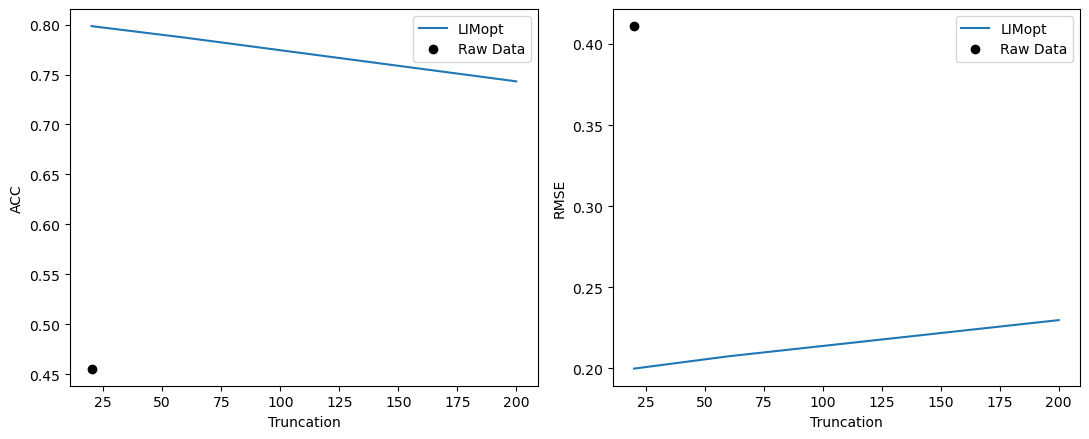

In [21]:
f=plt.figure(figsize=(11, 4.5))
plt.subplot(1, 2, 1)
plt.plot(truncations, np.mean(np.mean(corr,axis=1),axis=0))
plt.plot(np.min(truncations),np.mean(np.mean(corr_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['LIMopt','Raw Data'])
plt.xlabel("Truncation")
plt.ylabel("ACC")
plt.subplot(1, 2, 2)
plt.plot(truncations, np.sqrt(np.mean(np.mean(mse,axis=1),axis=0)))
plt.plot(np.min(truncations),np.mean(np.mean(mse_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['LIMopt','Raw Data'])
plt.xlabel("Truncation")
plt.ylabel("RMSE")
plt.tight_layout()

## LIMopt of evaluation members

Now that we have undergone the time intensive task of training, we can choose values of `truncation` based on the above plots (there is no right way to do this), apply LIMopt to the evalution members, and visualize the results. 

In [22]:
# manually set hyperparameters (based on training)
truncation = 60

# initialize dictionaries for LIMopt output
alphas_eval_all = {}
limopts_eval_all = {}
X_forced_eval_all = {}
X_total_eval_all = {}

eval_models = evaluation_anomaly_maps.keys()

for ie, eval_model in enumerate(eval_models):
    
    print("Model " + eval_model)
    
    # convert missing data mask from nans to zeros
    mask = np.nan_to_num(missing_data_mask[eval_model], nan=0)
    
    alphas_eval_all[eval_model] = {}
    limopts_eval_all[eval_model] = {}
    X_forced_eval_all[eval_model] = {}
    X_total_eval_all[eval_model] = {}
    
    # this is the data from each training model/member
    sst_anomalies = evaluation_anomaly_maps[eval_model]

    # extract coordinate vectors (same for all models, so could be moved out of the loop)
    k = list(anomaly_maps[models[0]].keys())
    lon_axis = anomaly_maps[models[0]][k[0]].lon
    lat_axis = anomaly_maps[models[0]][k[0]].lat
    time = anomaly_maps[models[0]][k[0]].time
    # dimensions of the data matrix
    n_timesteps = len(time)
    nfeatures = nlat * nlon
    
    # create cos(lat) weighting, with mask for missing data 
    y, x = np.meshgrid(lat_axis,lon_axis)
    area = np.cos(y*np.pi/180.) * np.transpose(mask)
    area_weights = np.reshape(area,(nfeatures,1),order='F')

    # combine lat & lon into a single spatial dimension
    x_all = sst_anomalies.stack(shape=['lat','lon'])

    # these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
    icol_ret = np.where(area_weights!=0)
    icol_disc = np.where(area_weights==0)
    # remove missing spatial points from x and area_weights
    x = x_all[:,icol_ret[0]]
    area_weights = np.transpose(area_weights[icol_ret[0],:])

    # perform LIM for each evaluation model 
    limopts, alphas = limopt(x, lag, optlag, truncation, area_weights)

    # put back in missing data 
    nins = len(icol_disc[0])
    nrows = limopts.shape[0]
    limopts_aug = np.zeros((nrows,limopts.shape[1]+nins))
    limopts_aug[:] = np.nan
    limopts_aug[:,icol_ret[0]] = limopts
    
    # time axis
    time_plot = [t.year + t.month/12 for t in time.values]
    
    # forced response estimate from LIMopt
    X_forced = np.matmul(alphas[:,0:3],limopts_aug[0:3,:])
    X_forced = X_forced.reshape(n_timesteps,nlat,nlon)
    X_forced = xr.DataArray(X_forced, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
    
    # put output in library
    alphas_eval_all[eval_model] = alphas
    limopts_eval_all[eval_model] = limopts_aug
    X_forced_eval_all[eval_model] = X_forced
    X_total_eval_all[eval_model] = sst_anomalies

Model 1A
Model 1B
Model 1C
Model 1D
Model 1E
Model 1F
Model 1G
Model 1H
Model 1I
Model 1J


## Plot the LIMopts and their time series for two evaluation members of choice

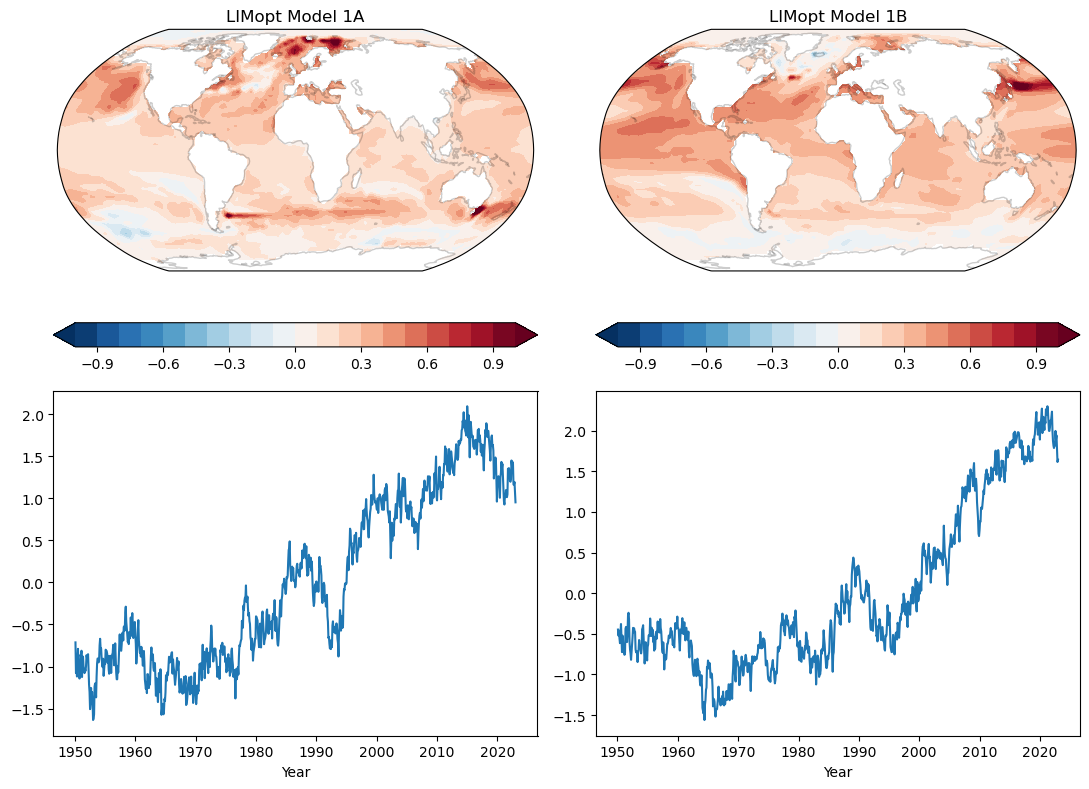

In [23]:
clev1 = np.arange(-1, 1.1, 0.1)
#clev1 = np.arange(-200, 205, 5)

plot_model = '1A'
alphas = alphas_eval_all[plot_model]
limopts_aug = limopts_eval_all[plot_model]

f=plt.figure(figsize=(11, 8))

i = 0 # LIMopt 1
pattern = np.reshape(limopts_aug[i,...],(nlon,nlat),order='F')
pattern[np.where(np.abs(pattern)>1.e5)] = np.nan
plt.subplot(2, 2, 1, projection=ccrs.Robinson())
map_plot = np.transpose(pattern)
cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clev1, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
# coastlines
plt.gca().set_global()
plt.gca().coastlines(alpha=0.2)
# colorbar
plt.colorbar(orientation='horizontal')
plt.title('LIMopt Model '+plot_model)
plt.subplot(2, 2, 3)
plt.plot(time_plot,alphas[:,i])
plt.xlabel("Year")

plot_model = '1B'
alphas = alphas_eval_all[plot_model]
limopts_aug = limopts_eval_all[plot_model]

i = 0 # LIMopt 1
pattern = np.reshape(limopts_aug[i,...],(nlon,nlat),order='F')
pattern[np.where(np.abs(pattern)>1.e5)] = np.nan
plt.subplot(2, 2, 2, projection=ccrs.Robinson())
map_plot = np.transpose(pattern)
cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clev1, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
# coastlines
plt.gca().set_global()
plt.gca().coastlines(alpha=0.2)
# colorbar
plt.colorbar(orientation='horizontal')
plt.title('LIMopt Model '+plot_model)
plt.subplot(2, 2, 4)
plt.plot(time_plot,alphas[:,i])
plt.xlabel("Year")

plt.tight_layout()

## LIMopt filtered trends over the full time period (based on chosen tier)

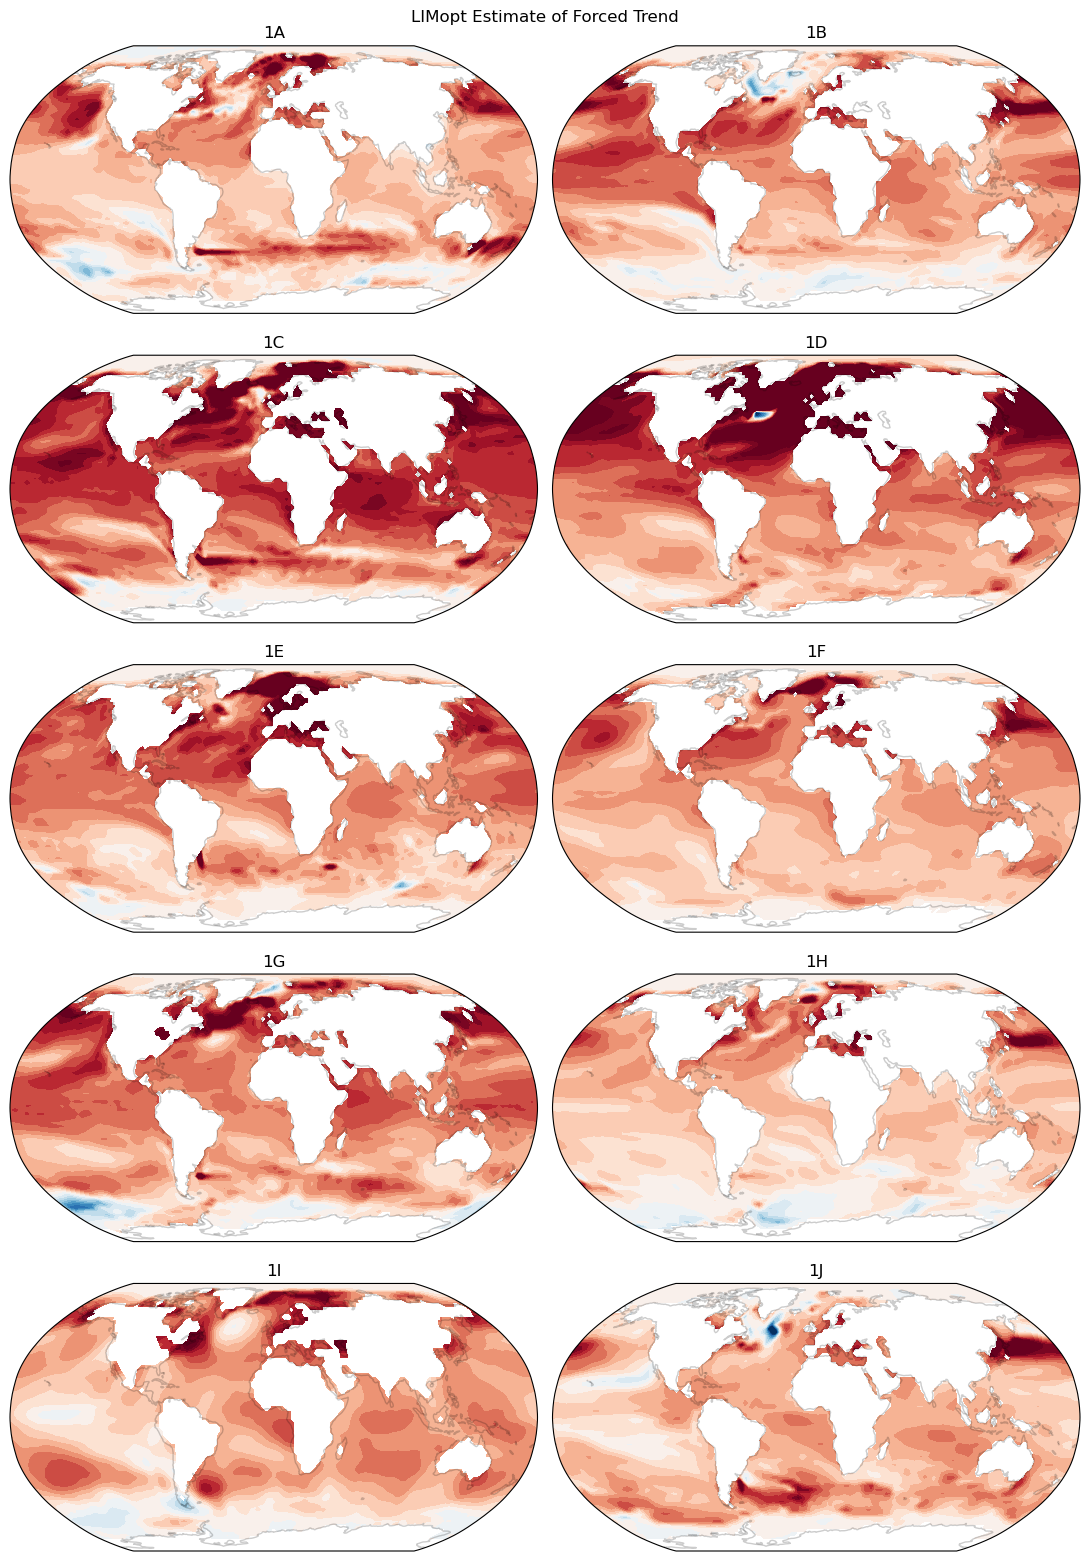

In [24]:
clevs = np.arange(-2, 2.2, 0.2)

f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1, projection=ccrs.Robinson())
    X_forced = X_forced_eval_all[eval_model]
    X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients
    map_plot = X_forced_trend.values*(time_plot[-1]-time_plot[0])
    cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
    im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(eval_model)
plt.suptitle('LIMopt Estimate of Forced Trend')
plt.tight_layout()

## Visualizing LIMopt Filtering for Global Mean

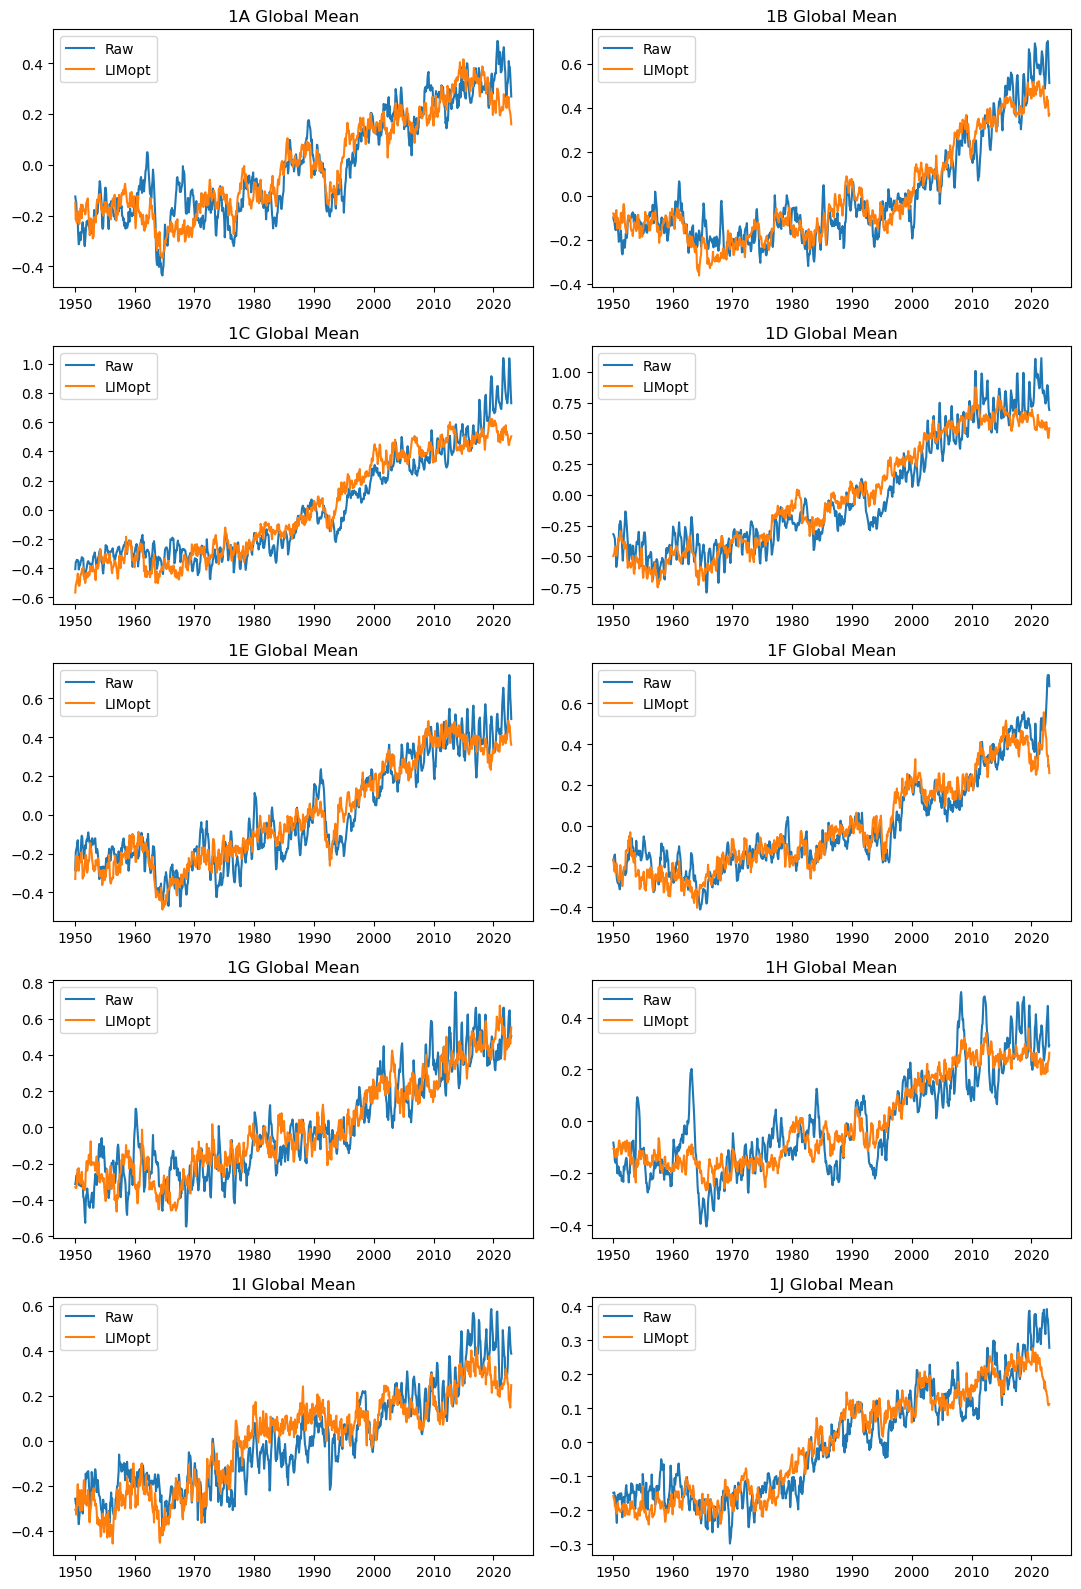

In [25]:
time_plot = [t.year + t.month/12 for t in time.values]
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    GMST_total = X_total.mean('lon').mean('lat')
    GMST_forced = X_forced.mean('lon').mean('lat')
    plt.plot(time_plot,GMST_total)
    plt.plot(time_plot,GMST_forced)
    plt.title(eval_model+' Global Mean')
    plt.legend(['Raw','LIMopt'])
plt.tight_layout()

## And the same visualization for Niño3.4 region

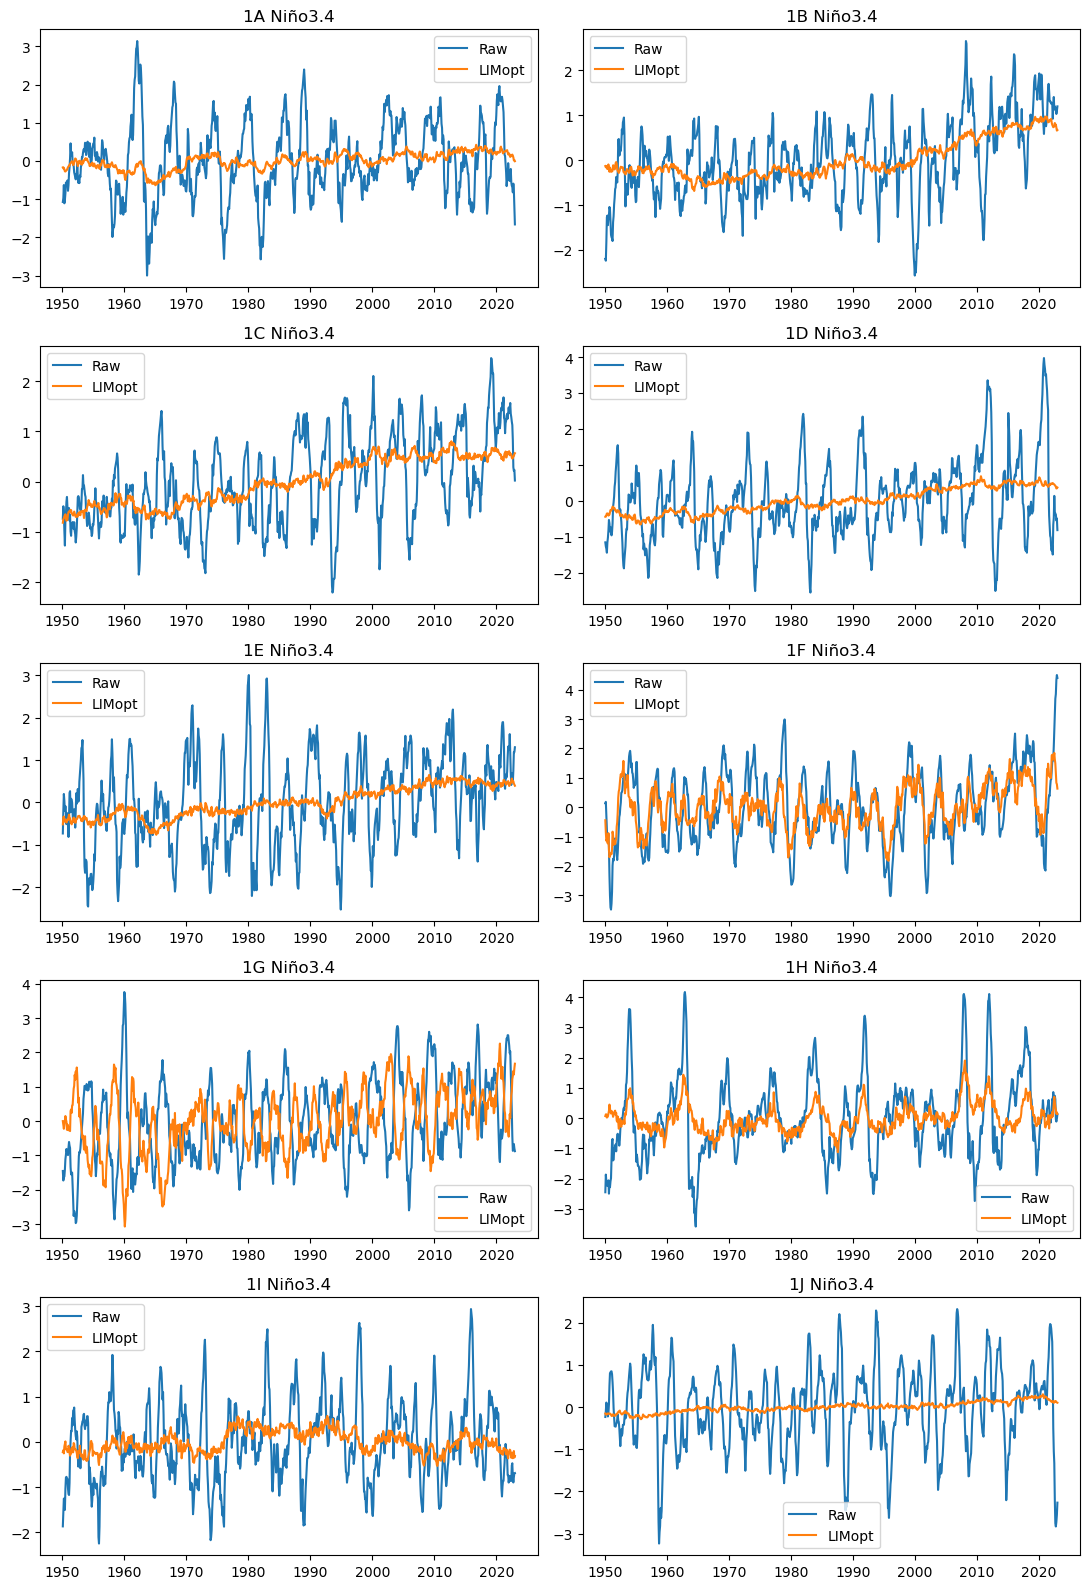

In [26]:
time_plot = [t.year + t.month/12 for t in time.values]
cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    Nino34_forced = (X_forced*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    Nino34_total = (X_total*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    # if you want to compute the global mean and subtract that from Nino34:
    #GMST_total = (X_total*cosw).mean('lon').mean('lat')
    #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
    plt.plot(time_plot,Nino34_total)
    plt.plot(time_plot,Nino34_forced)
    plt.title(eval_model+' Niño3.4')
    plt.legend(['Raw','LIMopt'])
plt.tight_layout()

## And the same visualization for the grid cell corresponding to Boulder or Zurich

In [27]:
location = 'Zurich'

if ncvar == "tos":
    print('Skipping plot for ocean variable')
else:
    if location == 'Zurich':
        sel_lat = 47.4 # closest to 47.4°N
        sel_lon = 8.5 # closest to 8.5°E
    elif ftype == 'Boulder':
        sel_lat = 40.02 # closest to 40.02°N
        sel_lon = 254.7 #closest to 105.3°W
    else:
        raise ValueError('Only has options for Zurich and Boulder.')

    time_plot = [t.year + t.month/12 for t in time.values]
    cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
    f = plt.figure(figsize=(11, 16))
    for ie, eval_model in enumerate(eval_models):
        plt.subplot(5, 2, ie+1)
        X_forced = X_forced_eval_all[eval_model]
        X_total = X_total_eval_all[eval_model]
        Nino34_forced = (X_forced).sel(lon=8.75, lat=47.4, method='nearest')
        Nino34_total = (X_total).sel(lon=8.75, lat=47.4, method='nearest')
        # if you want to compute the global mean and subtract that from Nino34:
        #GMST_total = (X_total*cosw).mean('lon').mean('lat')
        #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
        plt.plot(time_plot,Nino34_total)
        plt.plot(time_plot,Nino34_forced)
        plt.title(eval_model+' '+location)
        plt.legend(['Raw','LIMopt'])
    plt.tight_layout()

Skipping plot for ocean variable


### Discussion Questions

* Do you think this approach (LIMopt) would work well for other variables of interest?
* Are 'lag' and 'optlag' also hyperparameters? You could think about training for the best values of them as well. Look into Frankignoul et al. (2017) and Solomon & Newman (2012) for more about these parameters. 
* This notebook doesn't use the iterative filter discussed in Frankignoul et al. (2017), i.e., it uses $tau_1 = 0$. How would you go about adding this iterative filter? (Caution: this is not easy. See Wills et al. 2020 supplemental information for an example of how it changes the results.)
* Some authors have used ordinary LIM insteaf of LIMopt. This notebook is a good starting point for investigating ordinary LIM. 
* How would you choose between optimizing the skill metrics presented? Can you think of other skill metrics to use?
* We've evaluated the monthly variability and the full-period trend. How about timescales in between (e.g., annual means, 5-year means)? 

### NetCDF Output of Forced Response Estimate

In [28]:
eval_model = "1H" # 3I
name = "LIMopt.Wills"
outdir = "/home/rjnglin/ForceSMIP_estimates/"
filename = outdir+eval_model+"."+ncvar+"."+name+".nc"

X_forced = X_forced_eval_all[eval_model]
X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients*np.ceil(time_plot[-1]-time_plot[0])
X_forced_trend = X_forced_trend.rename("forced_component")

print ('saving to ', filename)
X_forced_trend.to_netcdf(path=filename)
X_forced_trend.close()
print ('finished saving')

saving to  /home/rjnglin/ForceSMIP_estimates/1H.tos.LIMopt.Wills.nc
finished saving
